### Model

|Type  | Symbol              | Code     | Description     |
|:-----|:-------------------:|:---------|:----------------|
|      | $O_{j}(t,\lambda)$  | O        | observed signal from the $j$-th laser at time $t$ at spectral wavelength $\lambda$  | 
|Const | $s_{i}(\lambda)$    | S        | emission spectrum of sensor associated with $i$-th neuromodulator                   | 
|Const | $e_{j}(\lambda)$    | E        | time-invariant spectral signature of $j$-th excitation laser                        | 
|Const | $\mu_\textrm{oxy}(\lambda)$   | Mu_ox  | Spectrum of oxygenated hemolobin                                            |
|Const | $\mu_\textrm{deoxy}(\lambda)$ | Mu_dox | Spectrum of deoxygenated hemolobin                                          |
|Param | $w_{ij}$              | W        | emission efficiency of $i$-th neuromodulator excited by $j$-th laser              | 
|Param | $a_{i}(t)$            | A        | sensor signal from time varying amount for the $i$-th neuromodulator              | 
|Param | $n_{j}(t)$            | N        | noise from $j$-th laser                                                           | 
|Param | $b_{j}(\lambda)$      | B        | fiber fluorescence triggered by $j$-th laser                                      | 
|Param | $m(t)$                | M        | motion correction (potentially depends on $i$)                                    | 
|Param | $h_\textrm{oxy}(t)$   | H_ox     | Hemodynamics (oxygenated component)                                               |
|Param | $h_\textrm{deoxy}(t)$ | H_dox    | Hemodynamics (deoxygenated component)                                             |



\begin{align*}
O_{j}(t,\lambda)  &= \{ \left( \sum_{i \in \{\textrm{sensors}\},\textrm{autofluorescence}}{\left(a_{i}(t)s_{i}({\lambda})w_{ij}\right)} + e_{j}(\lambda) \right) &\\
& \times \left( h_{\textrm{oxy}}(t)\mu_{\textrm{oxy}}(\lambda)
+ h_{\textrm{deoxy}}(t)\mu_{\textrm{deoxy}}(\lambda) \right) \times m(t) &\\
&+ b_{j}(\lambda) \} \times n_{j}(t)
\end{align*}


- $a_{i}(t)$ for  $i \in \textrm{autofluorescence}$ is slow
- $a_{i}(t)$ for  $i \in \textrm{sensors}$ can be fast (prior: 50 ms to 1 s) or slow (prior: 10 s to 50 s)
- $a_{i}(t) := c_{i}\{f(t)s_\textrm{bright}(\lambda) + (1-f(t))s_\textrm{dark}(\lambda)\}$ : a single sensor population exists in two states (e.g. bright and dark) that have their own emission spectra (also see Isosbestic point).
- $n_{j}(t)$ : white noise spectrum, power mostly in high frequency components.
- $h_{\textrm{oxy}}(t), h_{\textrm{deoxy}}(t)$ : Slow dynamics, with the fastest dynamics occurring at 0.5 Hz
- For each $j$, a spectral band (around excitation wavelength $\lambda^{\dagger}_{j}$ ) has no information because the pixels are saturated. The diffraction pattern around these pixels is dominated by signal from the laser itself. This might provide an approximation for terms like $h_{\textrm{oxy}}(t)$ ... etc. These could be used as inputs instead of parameters to fit in the above equation.


$$
\def\lexc{\lambda^{\dagger}_{j}}
O_{j}(t,\lexc) = [e_{j}(\lexc) \times\{
h_{\textrm{oxy}}(t)\mu_{\textrm{oxy}}(\lexc)
+h_{\textrm{deoxy}}(t)\mu_{\textrm{deoxy}}(\lexc)\} \times m(t) + b_{j}(\lexc)] \times{n_{j}(t)}$$


In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

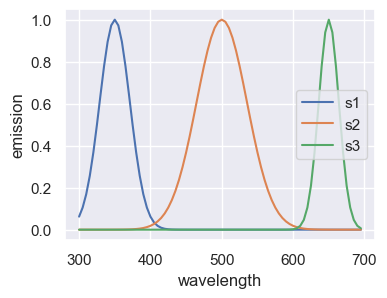

In [2]:
# O has shape n_channels (j), time (t), spectrum (lam)
from sourcesep.sim import emission_spectrum

# Simulated emission spectra
lam_range = np.arange(300, 700, 5)

s1 = emission_spectrum(lam_peak=350, lam_sigma=30, lam_range=lam_range)
s2 = emission_spectrum(lam_peak=500, lam_sigma=50, lam_range=lam_range)
s3 = emission_spectrum(lam_peak=650, lam_sigma=20, lam_range=lam_range)

f, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(lam_range, s1, label='s1')
ax.plot(lam_range, s2, label='s2')
ax.plot(lam_range, s3, label='s3')
ax.set(xlabel='wavelength', ylabel='emission')
plt.legend()
plt.show()

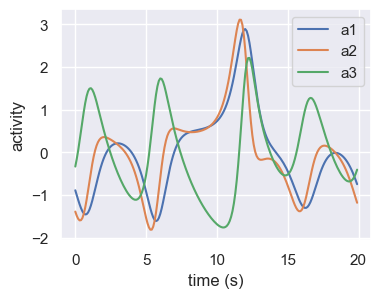

In [3]:
# check chaotic attractor time series
from dysts.flows import Lorenz

t = np.arange(0, 20, 0.1)
n_samples = t.size
model = Lorenz()
a = model.make_trajectory(n_samples, pts_per_period=100,
                          resample=True, standardize=True)
a1 = a[:, 0]
a2 = a[:, 1]
a3 = a[:, 2]

f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(t, a1, label='a1')
ax.plot(t, a2, label='a2')
ax.plot(t, a3, label='a3')
ax.set(xlabel='time (s)', ylabel='activity')
plt.legend()
plt.show()


In [4]:
# construct model as a sequence of matrix multiplications. 

import numpy as np
rng = np.random.default_rng()

# constants indicating shape of different simulation parameters and constants:

T = 10 #n_samples in time window
I = 3  #n_indicators
L = 20 #n_pixels (wavelengths)
J = 2  #n_laser channels

In [5]:
# 1st term
A = rng.random((T,I))
S = rng.random((I,L))
W = rng.random((I,J))
E = rng.random((J,L))

AS = np.einsum('ti,il->til', A, S)
print(f'AS shape: {AS.shape}')

ASW = np.einsum('til,ij->tjl', AS, W)
print(f'ASW shape: {ASW.shape}')

E = np.einsum('td,djl -> tjl', np.ones((T,1)), E[np.newaxis,...])
print(f'E shape: {E.shape}')
assert np.array_equal(E[0,...], E[1,...]), 'broadcasting check'

ASWE = ASW + E

AS shape: (10, 3, 20)
ASW shape: (10, 2, 20)
E shape: (10, 2, 20)


In [6]:
# 2nd term
H_ox = rng.random((T,))
Mu_ox = rng.random((L,))

H_dox = rng.random((T,))
Mu_dox = rng.random((L,))

HD = np.einsum('td,dl -> tl', H_ox[...,np.newaxis], Mu_ox[np.newaxis,...]) \
    + np.einsum('td,dl -> tl', H_dox[...,np.newaxis], Mu_dox[np.newaxis,...])
print(f'HD shape: {HD.shape}')

HD = np.einsum('j,tl -> tjl', np.ones((J,)), HD)
print(f'HD shape with j: {HD.shape}')
assert np.array_equal(HD[:,0,:], HD[:,1,:]),'broadcasting check'

M = rng.random((T,))
B = rng.random((J,L))

HDM = np.einsum('tjl,t -> tjl', HD, M)
B = np.einsum('t,jl -> tjl', np.ones((T,)), B)
H = HDM + B
print(f'H shape with j: {H.shape}')

HD shape: (10, 20)
HD shape with j: (10, 2, 20)
H shape with j: (10, 2, 20)


In [7]:
# 3rd term
N = rng.random((T,J))
N = np.einsum('l,tj -> tjl', np.ones((L,)), N)
assert np.array_equal(N[:,:,0],N[:,:,1]), 'broadcast check'

In [8]:
O = np.einsum('tjl,tjl -> tjl', ASWE, H)
O = np.einsum('tjl,tjl -> tjl', O, N)
print(f'O shape: {O.shape}')

O shape: (10, 2, 20)
